In [487]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/scoring/sf-dst-scoring/sample_submission.csv
/kaggle/input/scoring/sf-dst-scoring/train.csv
/kaggle/input/scoring/sf-dst-scoring/test.csv


In [488]:
from pandas import Series
import pandas as pd
import numpy as np
import pandas_profiling


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV

# DATA

In [489]:
df_train = pd.read_csv('../input/scoring/sf-dst-scoring/train.csv')
df_test = pd.read_csv('../input/scoring/sf-dst-scoring/test.csv')
sample_submission = pd.read_csv('../input/scoring/sf-dst-scoring/sample_submission.csv')

In [490]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [491]:
df_train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [492]:
df_test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [493]:
sample_submission.head()

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


In [494]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 2 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем 2-ками

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [495]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

Описание признаков:
* client_id - идентификатор клиента
* app_date - дата заявки
* education - образование
* sex - пол
* age - возраст
* car - наличие машины
* car_type - тип машины - иномарка или нет
* decline_app_cnt - количество прошлых отказов по заявкам
* good_work - флаг наличия "хорошей" работы
* score_bki - скор в бюро кредитных историй
* bki_request_cnt - количество запросов в БКИ
* region_rating - рейтинг региона
* home_address - классификатор домашнего адреса
* work_address - классификатор рабочего адреса
* income - доход
* sna
* first_time
* foreign_passport - флаг наличия загранпаспорта
* sample - флаг выборки - test/train
* default - наличие дефолта

In [496]:
data.sna.value_counts()

1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64

In [497]:
data.first_time.value_counts()

3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64

In [498]:
data.good_work.value_counts()

0    91917
1    18231
Name: good_work, dtype: int64

In [499]:
data.decline_app_cnt.value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
15        1
19        1
20        1
21        1
22        1
24        1
30        1
33        1
Name: decline_app_cnt, dtype: int64

In [500]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
81147,27949,04FEB2014,SCH,F,34,N,N,2,0,-1.977968,1,40,1,2,16000,1,2,N,1,0
65731,107559,27APR2014,GRD,M,27,N,N,0,1,-1.467613,4,70,2,3,85000,4,3,N,1,0
25772,15493,22JAN2014,GRD,F,36,Y,Y,0,0,-1.850537,2,80,2,3,92000,1,3,Y,0,2
23654,52790,01MAR2014,GRD,F,32,N,N,0,0,-2.320308,0,80,2,3,60000,1,3,Y,0,2
82681,97462,14APR2014,GRD,M,33,N,N,0,0,-2.832815,1,60,1,2,70000,1,4,Y,1,0


## **EDA - Cleaning and Prepping Data**

1. Обработка NAN

In [501]:
data.isna().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

Пропущенные значения есть только в столбце education.

In [502]:
data.education.value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

Заполним пропуски самым частым значением - SCH

In [503]:
data.education = data.education.fillna('SCH')

In [504]:
data.education.isna().sum()

0

2. Обработаем столбец с датами

In [505]:
data['app_date'] = pd.to_datetime(data['app_date'])
data['app_date'].sample(3)

82574   2014-03-24
53411   2014-02-22
33573   2014-01-25
Name: app_date, dtype: datetime64[ns]

In [506]:
# Посчитаем количество дней с самой ранней даты в датасете
data['app_date'] = data['app_date'].apply(lambda x: (x - data['app_date'].min()).days)

3. Разделим все признаки на 3 группы - числовые, категориальные, бинарные:

In [507]:
# числовые признаки
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'score_bki', 'region_rating', 'first_time']
# категориальные признаки
cat_cols = ['education', 'home_address', 'work_address', 'sna']
# бинарные признаки
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport']

4. Проверим распределение числовых признаков

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


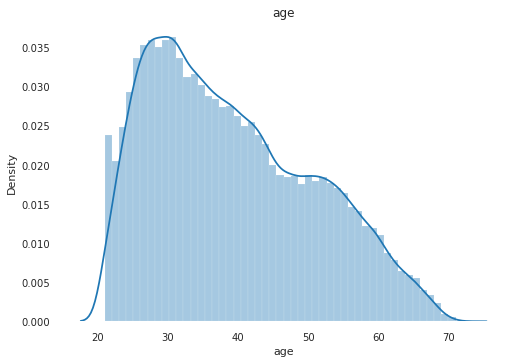

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


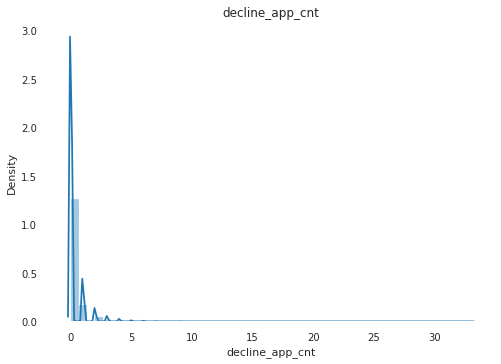

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


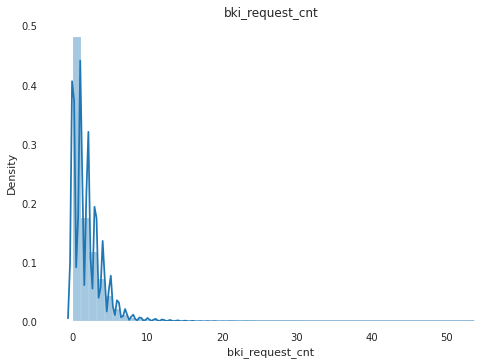

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


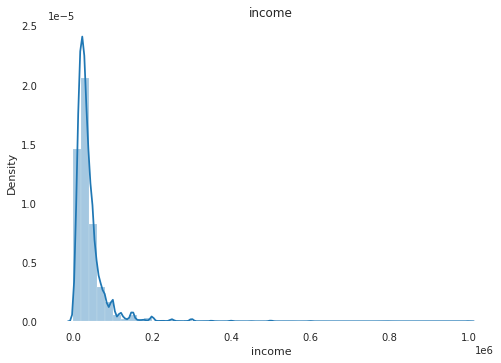

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


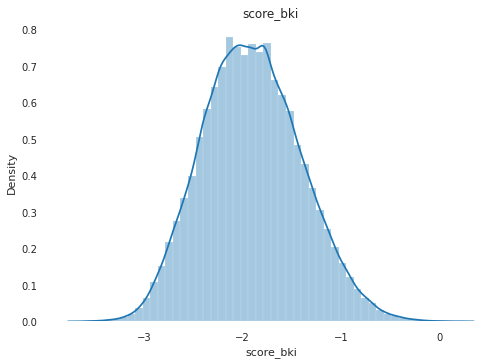

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


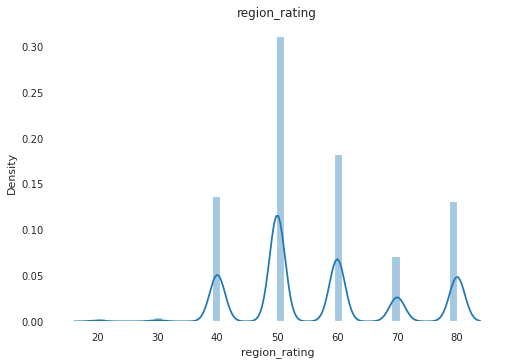

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


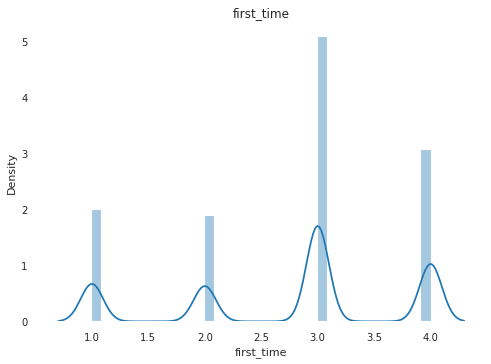

In [508]:
for i in num_cols:
    plt.figure()
    sns.distplot(data[i])
    plt.title(i)
    plt.show()

5. Проверим корреляцию числовых признаков

<AxesSubplot:>

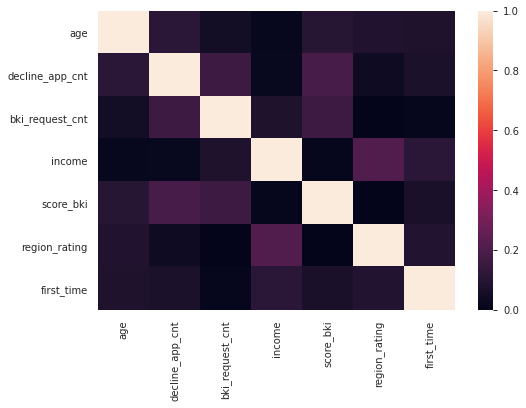

In [509]:
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

Корреляция между признаками < 0.4, поэтому на данном этапе никакие признаки удалять из модели не будем.

6. Оценим значимость числовых переменных для модели

<AxesSubplot:>

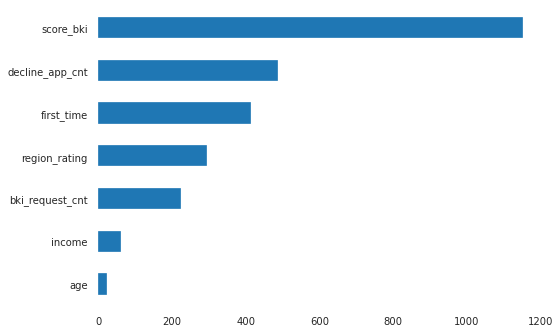

In [510]:
imp_num = Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Самые значимые признаки - score_bki, decline_app_cnt

7. Обработаем категориальные и бинарные признаки

In [511]:
# Для бинарных признаков мы будем использовать LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data[column] = label_encoder.fit_transform(data[column])
    
# убедимся в преобразовании    
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,80,GRD,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,2
1,17527,23,SCH,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,0,2
2,75683,81,UGR,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0,2
3,26883,33,SCH,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,0,2
4,28862,34,GRD,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,0,2


In [512]:
#Зададим числовое соответствие значениям в столбце education

label_encoder = LabelEncoder()

data['education'] = label_encoder.fit_transform(data['education'])
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,80,1,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,2
1,17527,23,3,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,0,2
2,75683,81,4,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0,2
3,26883,33,3,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,0,2
4,28862,34,1,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,0,2


Проверим значимость категориальных признаков

<AxesSubplot:>

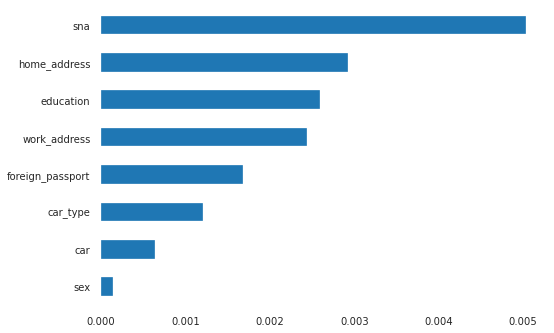

In [513]:
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Самые значимые параметры для модели - sna, home_address

In [514]:
#Применим dummy-кодирование для категориальных переменных
data = pd.get_dummies(data, columns=cat_cols, dummy_na=True)

In [515]:
data.sample(5)

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,home_address_nan,work_address_1.0,work_address_2.0,work_address_3.0,work_address_nan,sna_1.0,sna_2.0,sna_3.0,sna_4.0,sna_nan
106039,51099,57,0,23,0,0,0,0,-1.612473,2,...,0,0,1,0,0,1,0,0,0,0
91434,49213,56,1,37,1,0,1,0,-1.700974,3,...,0,0,1,0,0,1,0,0,0,0
88331,44489,50,0,28,1,0,0,1,-2.175620,2,...,0,0,0,1,0,1,0,0,0,0
73185,3999,9,0,32,0,0,0,0,-2.400023,1,...,0,0,1,0,0,1,0,0,0,0
60696,80553,86,0,21,0,0,0,0,-1.802568,0,...,0,1,0,0,0,0,0,1,0,0


8. Стандартизируем числовые переменные

In [516]:
data[num_cols] = pd.DataFrame(StandardScaler().fit_transform(data[num_cols]), columns = data[num_cols].columns)

In [517]:
data.sample(5)

,client_id,app_date,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,home_address_nan,work_address_1.0,work_address_2.0,work_address_3.0,work_address_nan,sna_1.0,sna_2.0,sna_3.0,sna_4.0,sna_nan
64048,78000,83,0,-0.629398,0,0,-0.341893,0,0.151750,-0.002207,...,0,0,1,0,0,0,1,0,0,0
19617,19480,26,1,1.627937,1,1,-0.341893,0,-0.922381,-0.443335,...,0,0,1,0,0,1,0,0,0,0
51968,55578,62,1,-0.976680,0,0,-0.341893,0,-1.652946,0.438921,...,0,0,1,0,0,1,0,0,0,0
8837,37755,43,0,1.367475,0,0,-0.341893,1,-1.684422,-0.884463,...,0,0,0,1,0,1,0,0,0,0
70379,52279,58,0,-0.889859,0,0,0.909522,0,0.758048,-0.884463,...,0,0,0,1,0,1,0,0,0,0


# Строим модель

In [518]:
def count_metrics(y_test, y_pred, y_probs):    
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics['f1'] = f1_score(y_test, y_pred)
    metrics['roc_auc'] = roc_auc_score(y_test, y_probs)  
    metrics['confusion'] = confusion_matrix(y_test, y_pred)
    return metrics 

def show_roc_auc(y_test, y_probs):
    fpr, tpr, threshold = roc_curve(y_test, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

In [519]:
data_train = data.query('sample == 1').drop(['sample','client_id'], axis=1)
data_test = data.query('sample == 0').drop(['sample','client_id'], axis=1)

In [520]:
X = data_train.drop(['default'], axis=1).values
Y = data_train['default'].values # целевая переменная

In [521]:
#Разделим данные для обучения:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [522]:
# Логистическая регрессия 
model_naive = LogisticRegression(max_iter = 1000)

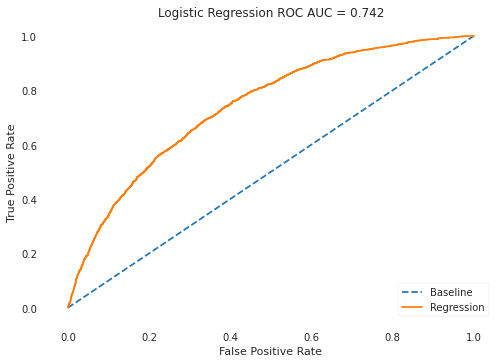

,naive
accuracy,0.874458
f1,0.041386
roc_auc,0.741585
confusion,"[[12867, 66], [1787, 40]]"


In [523]:
model_naive.fit(X_train, y_train)
y_pred = model_naive.predict(X_test)
y_probs = model_naive.predict_proba(X_test)[:,1]

#посмотрим метрики
metrics_naive = count_metrics(y_test, y_pred, y_probs)
data_metrics = pd.DataFrame.from_dict(metrics_naive, orient='index',columns = ['naive'])

show_roc_auc(y_test, y_probs)
display(data_metrics)

Значение ROC AUC довольно высоко, построим confusion matrixx

# Confusion matrix

[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

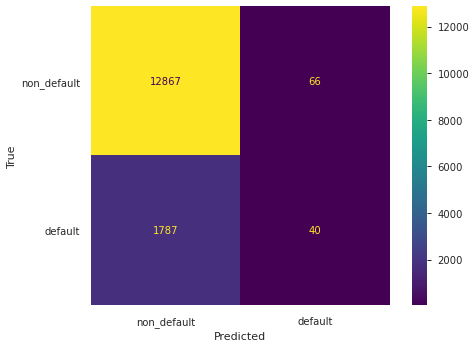

In [524]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['non_default','default'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

Видим ошибку II рода, недефолт модель угадывает лучше, значит мы будем выдавать кредиты почти всем.
Проверю распределение целевой переменной

<AxesSubplot:xlabel='default', ylabel='count'>

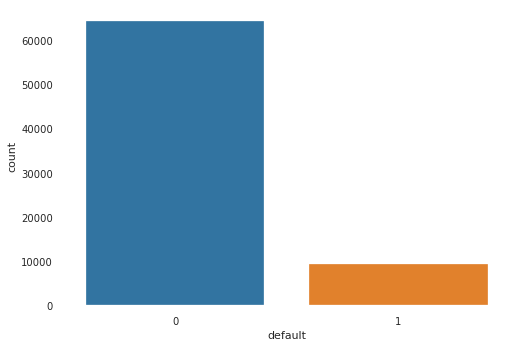

In [525]:
sns.countplot(x = data_train['default'], data = data_train)

# Модель с underfitting

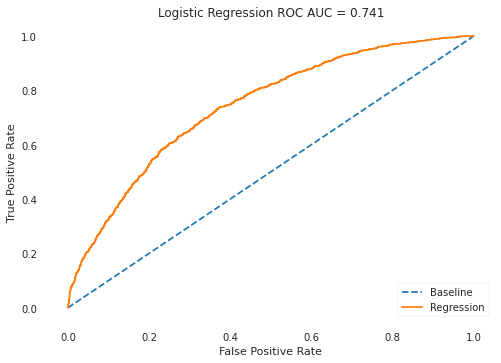

,naive,balanced
accuracy,0.874458,0.679648
f1,0.041386,0.680160
roc_auc,0.741585,0.741001
confusion,"[[12867, 66], [1787, 40]]","[[1271, 616], [585, 1277]]"


In [526]:
#выравниваю категории
classes = data_train.default.value_counts(ascending=True)
minor = data_train[data_train.default == classes.index[0]]
other = data_train[data_train.default.isin(classes.index[1:])][:classes.iloc[0]]
data_train_balanced = pd.concat([other, minor])

X = data_train_balanced.drop(['default'], axis=1).values
Y = data_train_balanced['default'].values

# Делю данные на еще один тест и трейн
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

#само обучение
model_balanced = LogisticRegression(solver = 'liblinear')
model_balanced.fit(X_train, y_train)
y_pred = model_balanced.predict(X_test)
y_probs = model_balanced.predict_proba(X_test)[:,1]

#посмотрю метрики
metrics_balanced = count_metrics(y_test, y_pred, y_probs)
data_metrics['balanced'] = pd.Series(metrics_balanced)

show_roc_auc(y_test, y_probs)
display(data_metrics)

По confusion matrix видим, что теперь модель угадывает и дефотных и недефолтных равномерно. 
Теперь попробуем улучшить модель путем подбора гиперпараметров.

# Подбор гиперпараметров

In [527]:
# Попробуем улучшить модель путем подбора параметров - penalty and C, используя GridSearchCV
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(class_weight='balanced', solver='liblinear',  max_iter=1000)
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

best_penalty = best_model.best_estimator_.get_params()['penalty']
best_C = best_model.best_estimator_.get_params()['C']

print('Best penalty:', best_penalty)
print('Best C:', best_C)

Best penalty: l1
Best C: 7.742636826811269


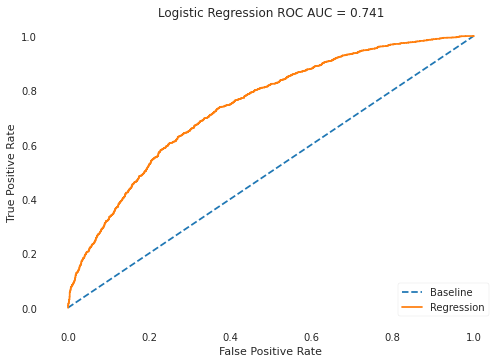

,naive,balanced,with hyperparameters
accuracy,0.874458,0.679648,0.679915
f1,0.041386,0.680160,0.680171
roc_auc,0.741585,0.741001,0.741024
confusion,"[[12867, 66], [1787, 40]]","[[1271, 616], [585, 1277]]","[[1273, 614], [586, 1276]]"


In [528]:
# train the model with the best penalty and C
model_3 = LogisticRegression(penalty=best_penalty, C=best_C, max_iter=1000, random_state=10, 
                             class_weight='balanced', solver='liblinear')

model_3.fit(X_train, y_train)
y_pred = model_3.predict(X_test)
y_probs = model_3.predict_proba(X_test)[:,1]

#посмотрим метрики
metrics_3 = count_metrics(y_test, y_pred, y_probs)
data_metrics['with hyperparameters'] = pd.Series(metrics_3)

show_roc_auc(y_test, y_probs)
display(data_metrics)

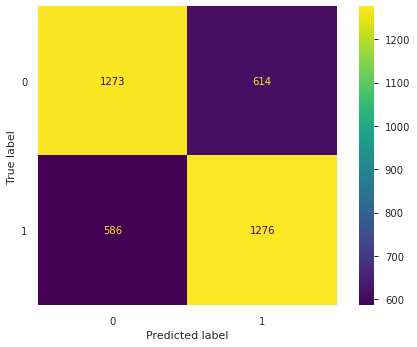

In [529]:
plot_confusion_matrix(model_3, X_test, y_test)

# Submission

In [530]:
sample_submission.sample(3)

,client_id,default
22070,96419,0.609497
9673,19468,0.320298
4998,97112,0.155598


In [531]:
X_train = data_train.drop(['default'], axis=1)
y_train = data_train.default.values
X_test = data_test.drop(['default'], axis=1)

In [532]:
data_test.shape, data_train.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 33), (73799, 33), (73799, 32), (73799,), (36349, 32))

In [537]:
last_model = LogisticRegression(random_state=10, penalty=best_penalty, C=best_C,  class_weight='balanced', dual=False, 
                            fit_intercept=True, intercept_scaling=1, l1_ratio=None, multi_class='auto',
                             n_jobs=None, tol=0.001, verbose=0, warm_start=False,
                                max_iter=1000, solver='liblinear')

last_model.fit(X_train, y_train)
y_pred_prob = last_model.predict_proba(X_test)[:,1]
y_pred = last_model.predict(X_test)

SyntaxError: keyword argument repeated (<ipython-input-537-c79839714679>, line 3)

In [534]:
submit = pd.DataFrame(df_test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)

In [535]:
display(submit)

,client_id,default
0,74835,0.208228
1,17527,0.799128
2,75683,0.299860
3,26883,0.403105
4,28862,0.159479
...,...,...
36344,83775,0.758521
36345,106254,0.096995
36346,81852,0.752173
36347,1971,0.635533
